In [1]:
import numpy as np
import math as mt
from PIL import Image as im
from matplotlib import pyplot as plt

In [2]:
def read_image(path):
    raw_image = im.open(path)
    image = np.array(raw_image)
    return image

def draw_image(vector):
    plt.figure()
    plt.imshow(np.reshape(vector, (256, 256)), 'gray', vmin = 0, vmax = 255)
    plt.axis('off')
    plt.show()

def img2arr(img):
    arr = img.reshape((1, img.shape[0] * img.shape[1]))
    return arr[0]

In [3]:
def histogram(image_arr):
    h = [0] * 256
    for intensity in image_arr:
        h[int(intensity)] += 1
    return h

def plot_hist(hist):
    plt.figure()
    plt.plot(range(256), hist)
    plt.show()

In [19]:
def init_a(L):
    a = [0] * (L + 2)
    for i in range(1, L + 1):
        a[i] = i * 256.0 / L
    a[L + 1] = 256
    return a

def init_a_alt(L, img_arr):
    mi = min(img_arr)
    ma = max(img_arr)
    a = [0] * (L + 2)
    for i in range(1, L + 1):
        a[i] = mi + float(ma - mi) / L * i
    a[0] = mi
    a[-1] = ma
    return a

def init_b(L):
    b = [0] * (L + 2)
    for i in range(L + 2):
        b[i] = i * 256.0 / L + 256.0 / (2 * L)
    return b

def init_b_alt(L, a):
    b = [0] * (L + 2)
    for i in range(0, len(a) - 1):
        b[i] = (a[i + 1] + a[i]) / 2
        if a[i + 1] == a[i]:
            step = b[1] - b[0]
            b[i] = b[i - 1] + step
    b[-1] = b[-2] + step
    return b
    
# we want to be sure that in the normal case (when use init_a, not init_a_alt) init_b_alt is
# fully compatible with init_b
def test_init_b_alt():
    L = 8
    a = init_a(L)
    b = init_b(L)
    b_alt = init_b_alt(L, a)
    assert(len(b) == len(b_alt))
    assert(b == b_alt)
    
test_init_b_alt() 

In [5]:
def density(h):
    sum = 0
    for el in h:
        sum += el
        
    p = [float(el) / sum for el in h]
    return p

def check_density(p):
    sum = 0
    for el in p:
        sum += el
    return sum == 1

In [22]:
def quantize(img_arr, a, b):
    arr = img_arr[:]
    for i in range(len(arr)):
        el = arr[i]
        nu = 0
        while el > a[nu]:
            nu += 1
            if nu == len(a):
                break
        intensity = b[nu - 1]
        arr[i] = intensity
    return arr

In [7]:
def plot_quantization_curve(a, b):
    a_plot = [a[0]]
    for i in range(1, len(a) - 1):
        a_plot += [a[i]] * 2 
    a_plot.append(a[-1])

    b_plot = []
    for el in b:
        b_plot += [el] * 2
    b_plot = b_plot[0:-2]

    a_plot[0] = 0
    a_plot[-1] = 256
    plt.figure()
    plt.plot(a_plot, b_plot)
    plt.show()

In [8]:
def error(L, a, b, p):
    err = 0
    for nu in range(1, L + 1):
        left = int(round(a[nu]))
        if left < 0:
            left = 0
        right = int(round(a[nu + 1]))
        if right > 255:
            right = 255
        for l in range(left, right):
            err += (l - b[nu]) ** 2 * p[l]
    
    return err
            

In [24]:
def main(folder_path, img_name, mode = 'default'):
    if mode == 'default':
        print img_name
    else:
        print img_name, 'Alternative initialization'
    img_path = folder_path + '/' + img_name
    image = read_image(img_path)
    arr = img2arr(image) # transform image to 1*n array.
    draw_image(arr)
    
    h = histogram(arr)
    # plot_hist(h)
    
    p = density(h)
    assert(check_density(p))
    
    L = 8
    if mode == 'default':
        a = init_a(L) # the first way to init a
    else:
        a = init_a_alt(L, arr)
    b = init_b_alt(L, a) # initially i used init_b. init_b is not possible to use with init_a_alt, 
    # as in this case 'a' breaks on the first iteration of the algorithm below.

    prev_err = float('inf')
    err = error(L, a, b, p)
    i = 0
    while err > 0.001 and err != prev_err: # stop when error is too low or when it stopped changing
        i += 1
        
        # calculate the new a
        for nu in range(1, L + 2):
            a[nu] = (b[nu] + b[nu - 1]) / 2

        for nu in range(0, L + 1):
            
            # a[nu] and a[nu + 1] could be not integer
            left = int(round(a[nu]))
            # Intenstity cannot be lower than 0 (see the task)
            if left < 0: 
                left = 0
    
            right = int(round(a[nu + 1]))
            # Intenstity cannot be higher than 255 (see the task)
            if right > 255:
                right = 255
                
            numerator = 0
            delimeter = 0
            for l in range(left, right):
                numerator += l * p[l]
                delimeter += p[l]
    
            # Do not change b[nu] if we did not find any pixels of intensity from a[nu] to a[nu] + 1
            if delimeter > 0:
                b[nu] = numerator / delimeter

        prev_err = err
        err = error(L, a, b, p)
    
    quantized = quantize(arr, a, b)
    draw_image(quantized)
    plot_quantization_curve(a, b)
    if prev_err == err:
        print 'Stopped because the error is not changing'
    else:
        print 'Stopped bacause the error is lower then a threshold'
    print 'iterations:', i
    print ''
    return a, b


bauckhage-gamma-1.png


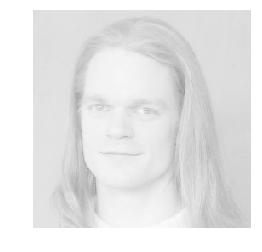

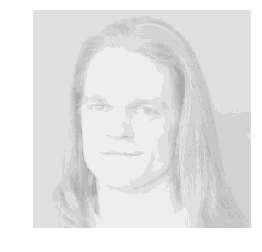

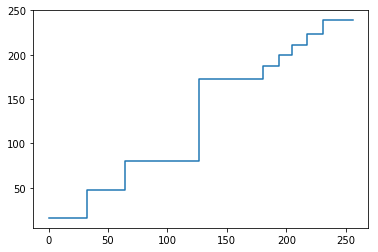

Stopped because the error is not changing
iterations: 14

bauckhage-gamma-2.png


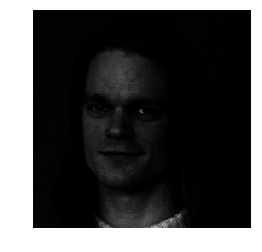

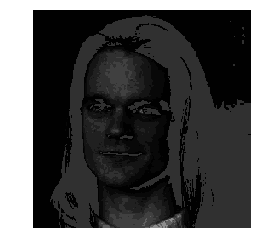

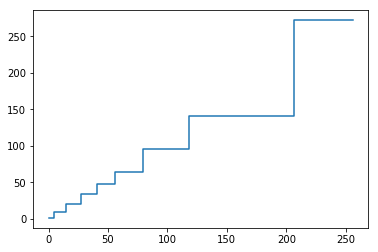

Stopped because the error is not changing
iterations: 50

bauckhage.jpg


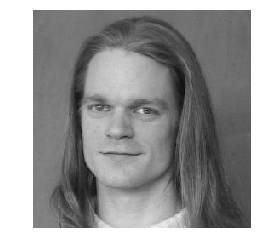

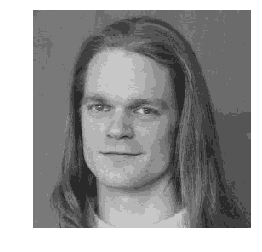

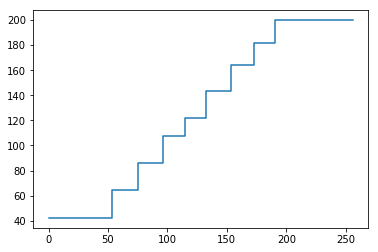

Stopped because the error is not changing
iterations: 32

bauckhage-gamma-1.png Alternative initialization


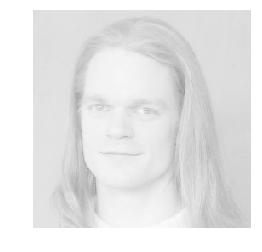

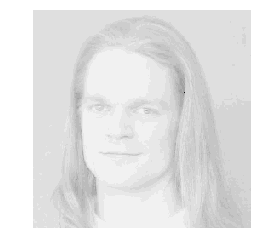

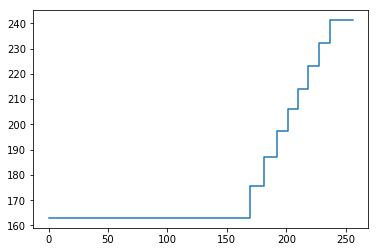

Stopped because the error is not changing
iterations: 12

bauckhage-gamma-2.png Alternative initialization


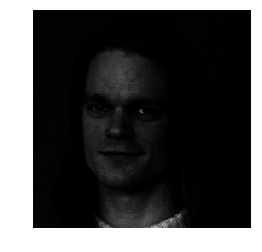

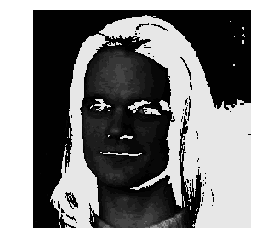

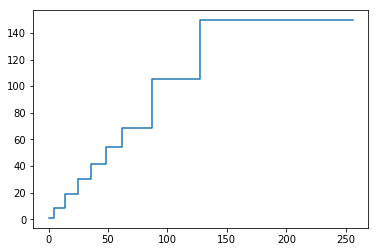

Stopped because the error is not changing
iterations: 45

bauckhage.jpg Alternative initialization


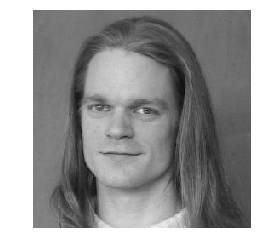

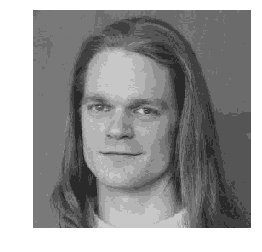

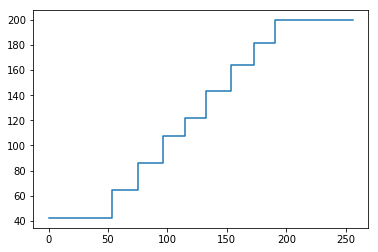

Stopped because the error is not changing
iterations: 30



([8,
  53.33886801987704,
  75.05045194353491,
  96.66326990308607,
  114.90519235891614,
  132.72902261463224,
  153.57166711894172,
  172.63436120057767,
  190.6099739693423,
  244.01644107191686],
 [42.23935483870968,
  64.4383812010444,
  85.66252268602541,
  107.66401712014674,
  122.14636759768555,
  143.31167763157896,
  163.8316566063045,
  181.43706579485084,
  199.78288214383375,
  288.25])

In [25]:
main('./images', 'bauckhage-gamma-1.png')
main('./images', 'bauckhage-gamma-2.png')
main('./images', 'bauckhage.jpg')
main('./images', 'bauckhage-gamma-1.png', 'alt')
main('./images', 'bauckhage-gamma-2.png', 'alt')
main('./images', 'bauckhage.jpg', 'alt')